In [1]:
# feature groups
rashod_r1 = ['f2','f3','f4','f5','f20','f22']
inside_r1_triple = ['f17','f25','f29','f32','f46','f47','f41']
inside_r1_double = ['f7','f8','f9']
inside_r1_unique = ['f39']

rashod_r2 = ['f10','f11','f12','f13','f21','f23']
inside_r2_triple = ['f18','f26','f31','f34','f51','f52','f50']
inside_r2_double = ['f14','f15','f16']

inside_r3_triple = ['f19','f27','f30','f33','f48','f49','f45']
inside_r3_unique = ['f36','f40']


weights = ['f53','f54','f55']
weather = ['f42','f43','f44']
temps_pro_wat_d219 = ['f1','f24','f38']
pressures_pro_az_etil = ['f6','f35','f37']
donor_in_nefras_level = ['f0']
bad = ['f28']
stars = ['f17','f18','f39','f50','f41','f38','f40','f45','f19'] # pred from activity gives e-2
rects = ['f52','f51','f46','f47','f48','f49','f36'] # pred from activity gives e-1

# groups of groups
rashod_r1_r2 = rashod_r1 + rashod_r2
inside_r1_r2 = inside_r1_triple + inside_r1_double + inside_r1_unique + inside_r2_triple + inside_r2_double
inside_r3 = inside_r3_triple + inside_r3_unique
unknown = weights + weather + temps_pro_wat_d219 + pressures_pro_az_etil + donor_in_nefras_level
together = rashod_r1_r2 + inside_r1_r2 + inside_r3 + unknown


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os,sys,inspect,pickle,json,time,datetime,re; root = os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))))
import random as rn
import utils
%matplotlib inline

conf = json.load(open('config_zoo.json'))
TARGET_ORIG = 'activity'
DATA_DIR = 'activity-atactic'
EXTRA_DATA1 = 'v00_original\\activity_test_timestamps.csv'
rn.seed(conf['rs'])
np.random.seed(conf['rs'])

# load
train_data_orig = pickle.load(open(os.path.join(root,'input',DATA_DIR,conf['data'],'train.pkl'),"rb"))
test_data_orig  = pickle.load(open(os.path.join(root,'input',DATA_DIR,conf['data'],'test.pkl'),"rb"))
features_orig = train_data_orig.columns.tolist(); features_orig.remove(TARGET_ORIG)

#train_data_orig = train_data_orig[:"2018-04-13"]
train_data_orig.shape # (300737, 331)


(300737, 331)

In [3]:
TRAIN_SPLIT = 250000#40000#200000#300#300#300000
BUFFER_SIZE = 10000#100#10000#100#10000
BATCH_SIZE = 256#1024#32#128#256##256
EVALUATION_INTERVAL = 50#2#200
EPOCHS = 3

past_history = 360#172#0#17200#0#720
future_target = 360#7#72
STEP = 1#100#10#6#6

features_considered = [TARGET_ORIG] + ['f53']#rashod_r1_r2#train_data_orig.columns.tolist()#['col1', 'col2', 'col3']

In [4]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import utils_lstm as utils
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

# dates = pd.to_datetime(pd.date_range('2018-02-13', periods=400, freq='MIN', name='date'), errors='coerce') # freq='T'
# col1 = np.arange(len(dates)) * 1 # np.random.randn(len(dates))
# col2 = np.array([np.sin(i/10) for i in range(1,(len(dates)+1))]) * 2 # np.random.randn(len(dates))
# col3 = np.array([np.sin(i/50) for i in range(1,(len(dates)+1))]) * 3 # np.random.randn(len(dates))
# train_data_orig = pd.DataFrame({'col1':col1,'col2':col2,'col3':col3}, index=dates)

features = train_data_orig[features_considered]
features.index = train_data_orig.index
dataset = features.values

print('train_data_orig',train_data_orig.shape, 'features',features.shape, 'dataset',dataset.shape)
#features.plot(subplots=True)

train_data_orig (300737, 331) features (300737, 2) dataset (300737, 2)


In [5]:
features.head(2)

,activity,f53
date,,
2018-02-13 14:31:00,26.492102,5247.641087
2018-02-13 14:32:00,34.102710,5000.878811


In [6]:
dataset[:, 0]

array([26.49210181, 34.10271023, 41.51822187, ..., 45.38970385,
       45.54252189, 45.06096939])

In [7]:
# norm
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [8]:
# split rows and cols
x_train_multi, y_train_multi = utils.multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = utils.multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
print('x_train_multi',x_train_multi.shape, 'y_train_multi',y_train_multi.shape)
print('x_val_multi',x_val_multi.shape, 'y_val_multi',y_val_multi.shape)


x_train_multi (249640, 360, 2) y_train_multi (249640, 360)
x_val_multi (50017, 360, 2) y_val_multi (50017, 360)


In [9]:
# join cols (tf input format)
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# compile
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))#(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [11]:
# fit
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/3
50/50 [==============================] - 56s 1s/step - loss: 71936614780.7613 - val_loss: 321773689.9133
Epoch 2/3
50/50 [==============================] - 39s 777ms/step - loss: 62162735226.8800 - val_loss: 3322054619.1144
Epoch 3/3
50/50 [==============================] - 39s 778ms/step - loss: 50603186872.3200 - val_loss: 1023731732.1910


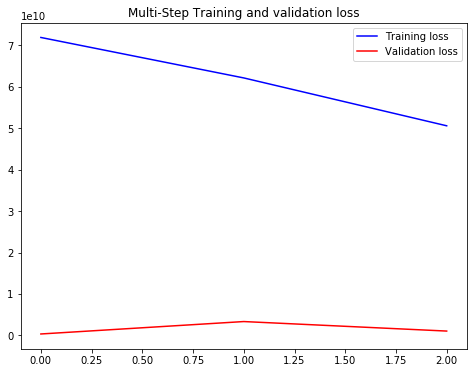

In [12]:
utils.plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

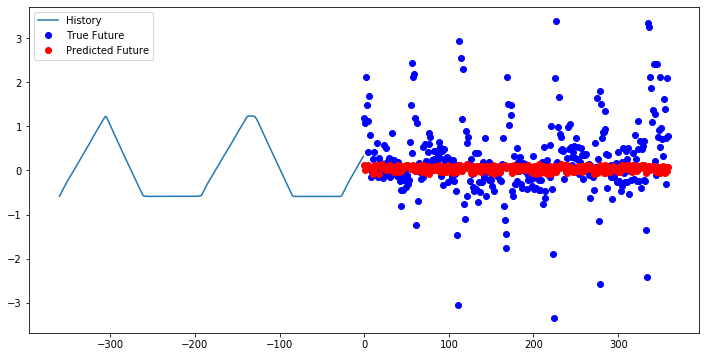

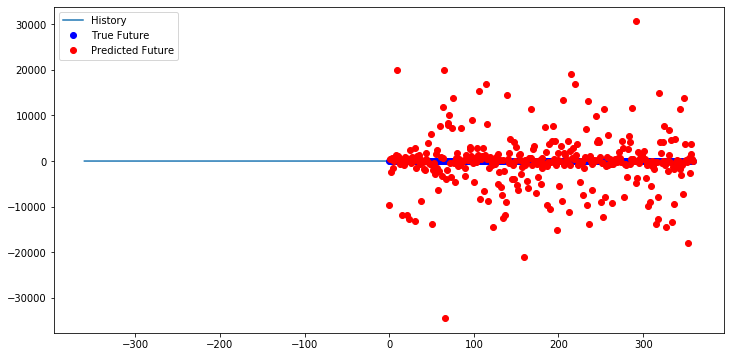

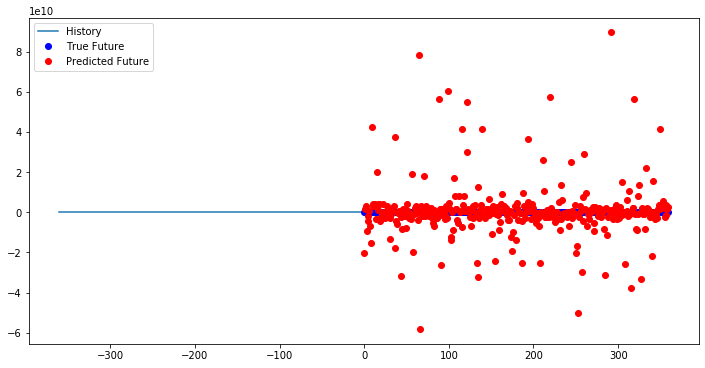

In [13]:
for x, y in val_data_multi.take(3):
  utils.multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], STEP)